In [3]:
import numpy as np
import pandas as pd
import os
import re
from datetime import timedelta
from datetime import datetime

In [4]:
def read_data_stromfluss(data_dir):
    """Read data from directory, get rid of '-' and NaN values, export a dataframe"""

    dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y')
    numberparse = lambda x: pd.np.float(x.replace(".", "").replace(",", ".")) if x != "-" else np.nan
    convert_thousand = {num: numberparse for num in np.arange(2, 22)}

    import_files = os.listdir(data_dir)

    for i in range(len(import_files)):
        if i == 0:
            df = pd.read_csv(os.path.join(data_dir, import_files[i]), sep=';', decimal=',', thousands='.',
                             parse_dates=['Datum'], date_parser=dateparse, converters=convert_thousand)
        else:
            df = df.append(pd.read_csv(os.path.join(data_dir, import_files[i]), sep=';', decimal=',', thousands='.',
                                       parse_dates=['Datum'], date_parser=dateparse, converters=convert_thousand))

    df.replace('-', 0, inplace=True)
    df.fillna(0, inplace=True)

    return df

def _create_datetime(row):
    """Helper Function

    Parameters
    ----------
    row : TYPE
        Description
    row : pd.Series

    Returns
    -------
    pd.Datetime
    """
    date = row.Datum.strftime("%Y-%m-%d") + " " + row.Uhrzeit
    return date

def preprocessing_stromfluss(df, basic = False):
    """Preprocessing für stromfluss Datansatz von Smard

    Parameters
    ----------
    df : pd.DataFrame
        stromfluss Datensatz von SMARD eingelesen und unbearbeitet

    Returns
    -------
    pd.DataFrame
        stromfluss Datensatz von SMARD aufbereitet zur weiteren Verwendung
    """

    # Time Formatting
    df["Date"] = df.apply(lambda row: _create_datetime(row), axis=1)
    df["Date"] = pd.to_datetime(df.Date, format="%Y-%m-%d %H:%M")
    df = df.sort_values("Date")

    cols = list(df)
    cols.insert(0, cols.pop(cols.index("Date")))
    df = df.loc[:, cols]

    # Rename columns
    countries = {
        "Niederlande": "NL",
        "Schweiz": "CHE",
        "Dänemark": "DNK",
        "Tschechien": "CZE",
        "Luxemburg": "LUX",
        "Schweden": "SWE",
        "Österreich": "AUT",
        "Frankreich": "FRA",
        "Polen": "PL",
    }

    types = {"Import": "IM", "Export": "EX"}

    type_pattern = r"\((.*?)\)"
    country_pattern = r"(.*?) "

    df.columns = list(df.columns[0:3]) + ['NX'] + [countries.get(re.search(country_pattern, col).group(1))+ "_"+ types.get(re.search(type_pattern, col).group(1)) for col in df.columns[4::]]

    # Netto Export
    df["NX"] = df.iloc[:, 4:].sum(axis = 1)
    
    #Drop columns
    df.drop(df.columns[1:3], axis=1, inplace = True)

    #Export only Datetime and NX for basic analysis
    if basic:
        df = df[['Date', 'NX']]

    return df

def get_training_sets(df: object, training_window_width: int, evaluation_days: list)->list:
    '''
    Provides a list containing pairs of training and validation sets for time series forecasts such as ARIMA. Validation is always done on all hours of a single day.
    :param df: pandas.DataFrame containing the time series data
    :param training_window_width: training window width in days. window width stays fix over validations
    :param evaluation_days: list of days on which to perform validations
    :return: list of evaluation sets
    '''

    evaluation_sets = []

    # Split the dataframe in training and evaluation data
    for day in evaluation_days:
        training_data = df[(df.index.date >((day - timedelta(days=training_window_width)).date()) & df.index.date < day.date())]
        evaluation_data = df[df.index.date == day.date()]

        evaluation_sets.append({"training_data": training_data, "evaluation_data": evaluation_data})

    return evaluation_sets

In [5]:
df = read_data_stromfluss("../data/stromfluss")
df = preprocessing_stromfluss(df, True)
df=df.set_index("Date")
df.head()

,NX
Date,
2015-06-01 00:00:00,7279.0
2015-06-01 01:00:00,7167.0
2015-06-01 02:00:00,6667.0
2015-06-01 03:00:00,6413.0
2015-06-01 04:00:00,5347.0


In [6]:
df2018 = df[(df.index.year == datetime(2018,1,1).year) & (df.index.month == datetime(2018,1,1).month)]
df2018.tail()

,NX
Date,
2018-01-31 19:00:00,5504.0
2018-01-31 20:00:00,6252.0
2018-01-31 21:00:00,8104.0
2018-01-31 22:00:00,8788.0
2018-01-31 23:00:00,9131.0


In [7]:
import statsmodels
from sklearn.metrics import mean_squared_error
import warnings
from statsmodels.tsa.arima_model import ARIMA
warnings.filterwarnings("ignore")

def evaluate_arima_model(X, arima_order, return_predictions=False):
    test = X.iloc[-24:]
    train = X.iloc[0:-24]
    history = [x for x in train]
    
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit(disp=0)
        
    #make predictions
    predictions = []
    for t in range(len(test)):
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        # history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test,predictions)
    if(return_predictions):
        return pd.DataFrame({"predictions":[x[0] for x in predictions], "actual":test})
    else:
        return error


def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))


Prepare Dataset

In [8]:
import matplotlib.pyplot as plt
import matplotlib

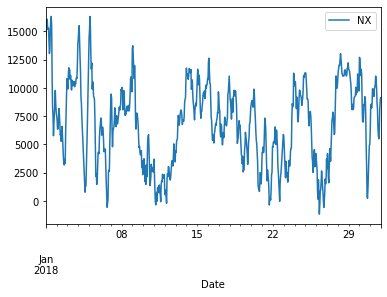

In [9]:
df2018['NX'][~((df2018['NX']-df2018['NX'].mean()).abs() > 3*df2018['NX'].std())]
df2018 = df2018.replace([np.inf, -np.inf], np.nan).dropna(how='all')
df2018.plot()

In [ ]:
# evaluate parameters
p_values = [24,48]
d_values = range(0,3)
q_values = range(0,3)
evaluate_models(df2018['NX'], p_values, d_values, q_values)


ARIMA(24, 0, 0) MSE=16070990.690
ARIMA(24, 0, 1) MSE=15131270.594
ARIMA(24, 0, 2) MSE=13938388.939
ARIMA(24, 1, 0) MSE=11995514.716
ARIMA(24, 1, 1) MSE=12344736.708
ARIMA(24, 1, 2) MSE=12163402.937
ARIMA(24, 2, 0) MSE=14008543.075


In [11]:
predictions = evaluate_arima_model(df2018['NX'], (0,0,0), True)